## Installation

In [1]:
! git clone https://github.com/WangShaoRu/pose-diff.git
! cd pose-diff && git submodule update --init --recursive --remote
# 安装cmake
! wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
! tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
# 安装依赖文件
! cd pose-diff/openpose && chmod -R a+x ./scripts && ./scripts/ubuntu/install_deps.sh
# make
! cd pose-diff/openpose && mkdir build && cd build && cmake -DBUILD_PYTHON=ON -DDOWNLOAD_FACE_MODEL=OFF -DDOWNLOAD_HAND_MODEL=OFF ..
# build
! cd pose-diff/openpose/build/ && make -j`nproc`

Cloning into 'pose-diff'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 61 (delta 19), reused 53 (delta 14), pack-reused 0
Unpacking objects: 100% (61/61), done.
Submodule 'openpose' (https://github.com/CMU-Perceptual-Computing-Lab/openpose) registered for path 'openpose'
Cloning into '/content/pose-diff/openpose'...
Submodule path 'openpose': checked out 'de3bea5f715e877c3fc90ad975123a62ec6a42a3'
Submodule '3rdparty/caffe' (https://github.com/CMU-Perceptual-Computing-Lab/caffe.git) registered for path 'openpose/3rdparty/caffe'
Submodule '3rdparty/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'openpose/3rdparty/pybind11'
Cloning into '/content/pose-diff/openpose/3rdparty/caffe'...
Cloning into '/content/pose-diff/openpose/3rdparty/pybind11'...
Submodule path 'openpose/3rdparty/caffe': checked out 'c95002fb17c87c8150fbad1e7e8e3ea3cebc641f'
Submodule path 'open

## Getting Started
### Pose diff with image input:
**Command line mode.**
You will find `ref.jpg` and `test.jpg` in `result/` if all right.

In [1]:
import sys, os
os.chdir('/content/pose-diff')
! python pose_diff.py --ref ./input/ref.jpg --test ./input/test.jpg

Starting OpenPose Python Wrapper...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.


**An example of using Openpose and our PoseDiff module with image input.**

- Step 1: Import several modules


In [1]:
import sys, os
os.chdir('/content/pose-diff')
sys.path.append(os.path.join('./openpose/build/python'))
from openpose import pyopenpose as op
import cv2
import numpy as np
import matplotlib.pyplot as plt
from core import PoseDiff, PoseException
from core.pose_25 import VIS_KP
from utils import display_pose

- Step 2: Run Openpose

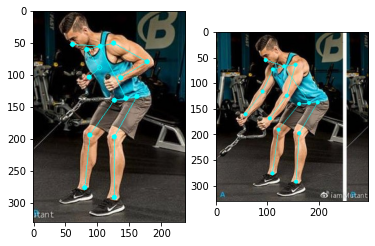

In [5]:
params = dict()
params['model_folder'] = os.path.join('./openpose/models')

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

# Process Reference Image and Display
datum = op.Datum()
ref_img_path = "./input/ref.jpg"
ref_img = cv2.imread(ref_img_path)
datum.cvInputData = ref_img
opWrapper.emplaceAndPop([datum])
ref_pose = datum.poseKeypoints[0][VIS_KP]
ref_img_with_pose = display_pose(ref_img, ref_pose, color=(255, 255, 0))
plt.subplot(1,2,1)
plt.imshow(ref_img_with_pose[:, :, ::-1])

# Process Test Image and Display
test_img_path = "./input/test.jpg"
test_img = cv2.imread(test_img_path)
datum.cvInputData = test_img
opWrapper.emplaceAndPop([datum])
test_pose = datum.poseKeypoints[0][VIS_KP]
test_img_with_pose = display_pose(test_img, test_pose, color=(255, 255, 0))
plt.subplot(1,2,2)
plt.imshow(test_img_with_pose[:, :, ::-1])

plt.show()

- Step 3: Pose Diff

[0.8262244016236112, 0.9657680412669123, 0.7869049490650092, 0.24602177401681133, 0.08702660246078771, 0.8072720324346013, 0.16103924000078648, 0.11751146559764765, 1, 0.852565426998666, 0.7935263488344337, 0.7028689725149408, 0.8450911074908909, 0.8015424951411138, 0.7342207914878551]


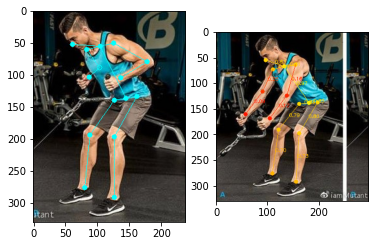

In [6]:
pd = PoseDiff()
try:
  scores = pd.pose_diff(ref_pose, test_pose)
except PoseException as e:
  print("Failed to matched! ", e)
  scores = None

print(scores)
test_img_with_pose_and_score = display_pose(test_img, test_pose, color=(0, 255, 255), scores=scores)

plt.subplot(1,2,1)
plt.imshow(ref_img_with_pose[:, :, ::-1])

plt.subplot(1,2,2)
plt.imshow(test_img_with_pose_and_score[:, :, ::-1])
plt.show()

### Pose diff with video input:
**Command line mode.**
You will find `ref.jpg` and `test.mp4` in `result/` if all right.

In [5]:
import sys, os
os.chdir('/content/pose-diff')
! python pose_diff.py --ref ./input/ref.png --test ./input/test.mp4

Starting OpenPose Python Wrapper...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.


**An example of using Openpose and our PoseDiff module with video input.**

In [14]:
import sys, os
os.chdir('/content/pose-diff')
sys.path.append(os.path.join('./openpose/build/python'))
from openpose import pyopenpose as op
import cv2
import numpy as np
import matplotlib.pyplot as plt
from core import PoseDiff, PoseException
from core.pose_25 import VIS_KP
from utils import display_pose

ref_img = cv2.imread('./input/ref.png')
test_video = './input/test.mp4'
restore_path = './result/test.mp4'

cap = cv2.VideoCapture(test_video)
(w, h) = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(restore_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            cap.get(cv2.CAP_PROP_FPS),
            (w, h))

params = dict()
params['model_folder'] = os.path.join('./openpose/models')

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

# Process Reference Image and Display
datum = op.Datum()

datum.cvInputData = ref_img
opWrapper.emplaceAndPop([datum])
ref_pose = datum.poseKeypoints[0]

ref_pose = ref_pose[VIS_KP]
ref_img_with_pose = display_pose(ref_img, ref_pose, color=(0, 255, 0))
test_poses = []
scores_list = []
while(True):
    ret, frame = cap.read()
    if ret:
        # Process Test Image and Display
        datum.cvInputData = frame
        opWrapper.emplaceAndPop([datum])
        test_pose = datum.poseKeypoints[0]
        
        test_pose = test_pose[VIS_KP]
        test_poses.append(test_pose)

        pd = PoseDiff()
        try:
            scores = pd.pose_diff(ref_pose, test_pose)
        except PoseException as e:
            print(e)
            scores = None
        scores_list.append(scores)
        test_img_with_pose = display_pose(
            frame, test_pose, color=(0, 255, 255), scores=scores)
        out.write(test_img_with_pose)
    else:
        break

cap.release()
out.release()

**Display the result**

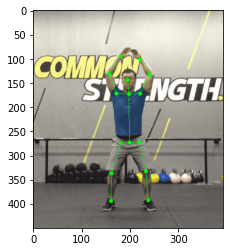

<Figure size 960x544 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
import numpy as np

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook
    
    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 144.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))
    
# Demo of plot_sequence_images
import cv2
video_path = "./result/test.mp4"
video = cv2.VideoCapture()
video.open(video_path)
imgs = []
while True:
    is_valid, img = video.read()
    if not is_valid: break
    imgs.append(img[:, :, ::-1])
video.release()

plt.imshow(ref_img_with_pose[:, :, ::-1])
plot_sequence_images(imgs)